In [32]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.model_selection  import train_test_split 
import statsmodels.formula.api as sm
from operator import itemgetter
import pysal as ps
#import rasterio
import itertools
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import copy as cp
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [33]:
# can use IMD score, as this relates to percentage of people experiencing a certain type of deprivation in a given area

In [34]:
data_co2 = pd.read_csv('Data/Footprint/bristol_CO2_data', encoding='latin-1').set_index('LSOA')
data_lsoa = gpd.read_file('Data/Spatial/LSOA_EW.shp').set_index('geo_code')
data_cen = pd.read_csv('Data/Census/all_data.csv').set_index('GEO_CODE')
data_imd = pd.read_csv('Data/Census/imd_all_score.csv').set_index('Reference area').join(gpd.read_file('Data/Spatial/LSOA_EW.shp').set_index('geo_label'), how = 'inner').set_index('geo_code').drop('http://opendatacommunities.org/def/ontology/geography/refArea', axis = 1).iloc[:,:9].join(data_co2[['Pastry']], how = 'inner').drop('Pastry', axis=1)

# IMD

In [35]:
data_imd.columns.to_list()

['a. Index of Multiple Deprivation (IMD)',
 'b. Income Deprivation Domain',
 'c. Employment Deprivation Domain',
 'd. Education, Skills and Training Domain',
 'e. Health Deprivation and Disability Domain',
 'f. Crime Domain',
 'g. Barriers to Housing and Services Domain',
 'h. Living Environment Deprivation Domain',
 'i. Income Deprivation Affecting Children Index (IDACI)']

In [36]:
data_imd.columns = data_imd.columns.str[0]
col_list = data_imd.columns.to_list()

In [37]:
ln_col_list = []
z_col_list = []
for item in col_list:
    data_imd[item +'_ln'] = np.log(data_imd[item] + 0.00001)
    ln_col_list.append(item + '_ln')

C:\Users\gylk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002772DCB55F8>,
      dtype=object)

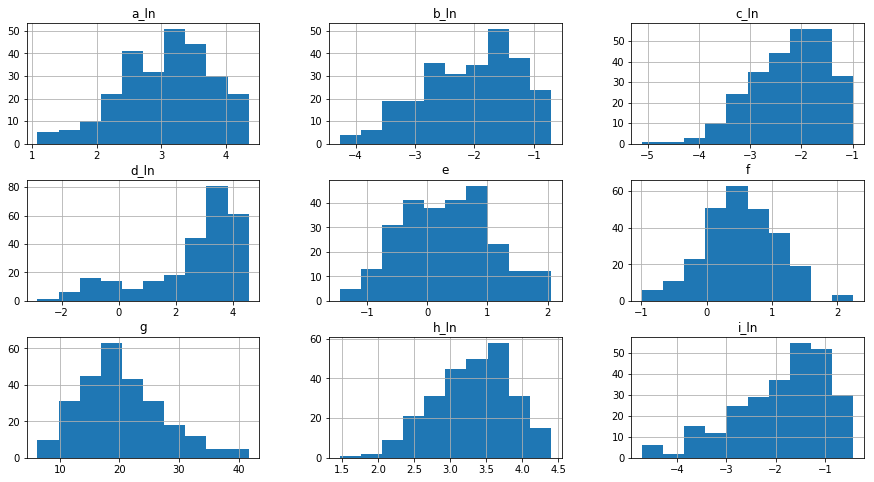

In [38]:
col_list_2 = ['a_ln', 'b_ln', 'c_ln', 'd_ln', 'e', 'f', 'g', 'h_ln', 'i_ln']

data_imd[col_list_2].hist(figsize=(15,8))

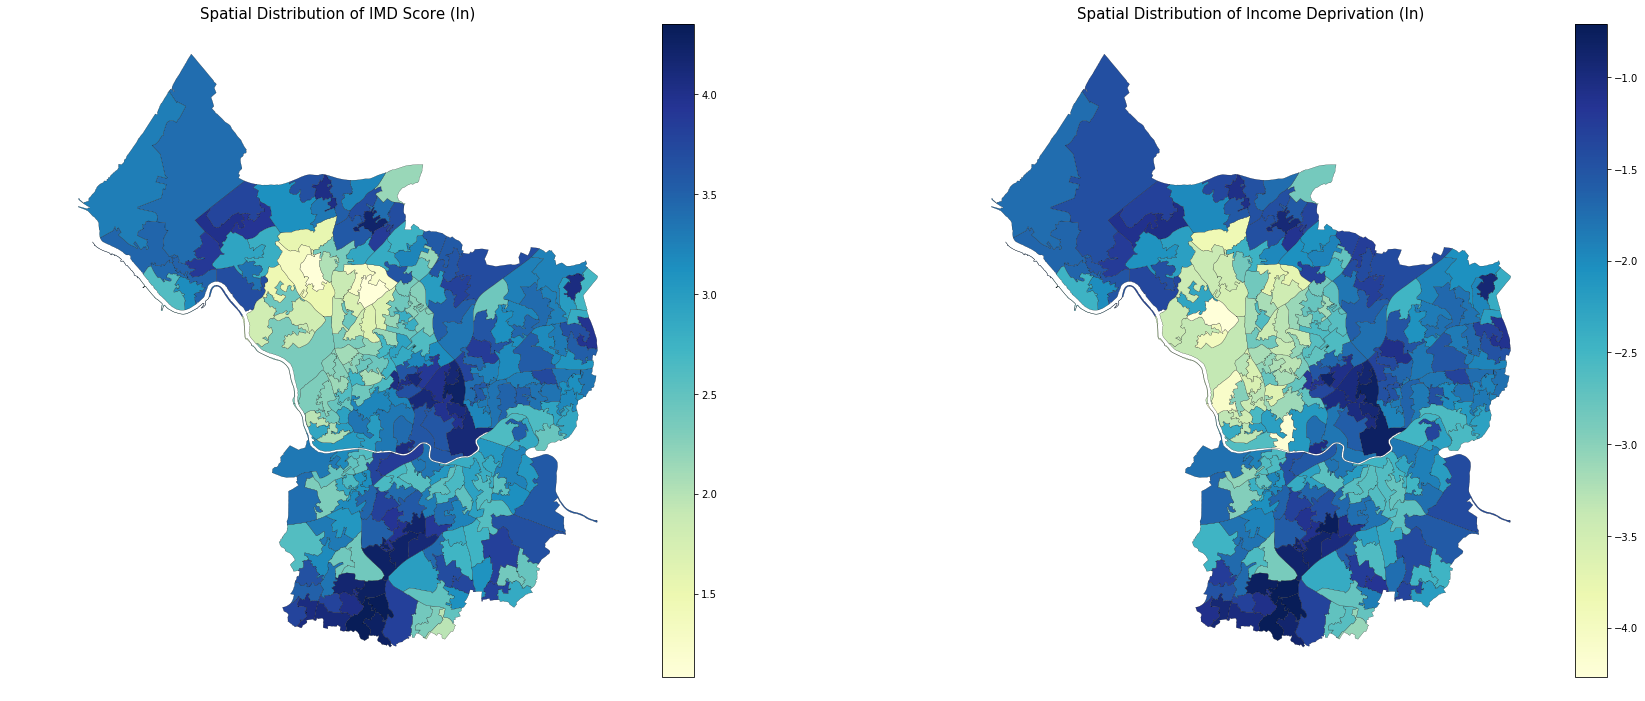

In [39]:
col_list = ['a_ln', 'b_ln']
titles = ['Spatial Distribution of IMD Score (ln)', 'Spatial Distribution of Income Deprivation (ln)']

fig, (axs) = plt.subplots(ncols=len(col_list), nrows=1, figsize=(30, 12))

for i in range(len(col_list)):
    data_lsoa.join(data_imd)\
         .join(data_cen, how = 'inner')\
         .plot(ax=axs[i],
               column=col_list[i], 
               #scheme = 'quantiles',
               cmap='YlGnBu',
               linewidth=0.2, edgecolor='black', 
               legend=True)\
         .set_title(titles[i], size=15)
    axs[i].set_axis_off()
plt.savefig('Outputs/'+col_list[i]+'.png')

In [40]:
data_imd[['a_ln', 'a']].describe()

,a_ln,a
count,263.000000,263.000000
mean,3.072119,26.956426
std,0.706326,17.186898
min,1.082825,2.953000
25%,2.536985,12.641500
50%,3.174004,23.903000
75%,3.582379,35.959000
max,4.350562,77.522000


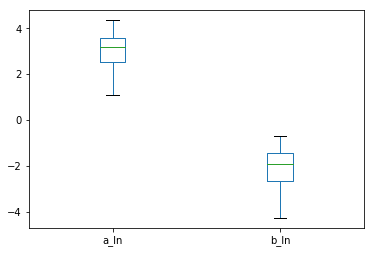

In [41]:
data_imd[col_list].plot(kind='box')

# CO2

## by person

In [42]:
data_co2_pop = data_co2.drop(['MSOA', 'LAD', 'LAD_nm', 'REG'], axis=1)

col_co2 = data_co2_pop.columns[:-1].to_list()

data_co2_pop['Pop'] = data_co2_pop['Pop'].str.replace(',', '')
for item in col_co2:
    data_co2_pop[item] = data_co2_pop[item].astype(float) * data_co2_pop['Pop'].astype(float)

In [43]:
pop_sum = 0
for i in range(len(data_co2_pop['Pop'])):
    pop_sum += int(data_co2_pop['Pop'][i])

In [61]:
bristol_sum = data_co2_pop.drop('Pop', axis =1).T

bristol_sum['bristol_tot'] = bristol_sum.sum(axis=1, skipna=True)
bristol_sum = bristol_sum[['bristol_tot']].sort_values('bristol_tot', ascending=False)
bristol_sum['bristol_mean']=bristol_sum['bristol_tot'] / pop_sum

In [63]:
bristol_sum.iloc[0:21, :]#.to_csv('Outputs/CO2_Commodity.csv')

In [66]:
bristol_sum.describe().T.sort_values('mean', ascending = False).iloc[:, 1:]#.to_csv('Outputs/CO2_Summary.csv')

,mean,std,min,25%,50%,75%,max
LSOA,,,,,,,
bristol_tot,54912.674146,331045.738913,0.0,2789.186000,6813.146000,18206.525000,3.761579e+06
bristol_mean,0.119826,0.722378,0.0,0.006086,0.014867,0.039729,8.208180e+00


In [67]:
col_co2 = data_co2.columns.to_list()

col_FoodDrink = col_co2[:39]
col_AlcTab = col_co2[39:45]
col_clothes = col_co2[45:57]
col_clothes.append(col_co2[127])
col_housing = col_co2[57:60]
col_energy = col_co2[60:64]
col_furniture = col_co2[64:73]
col_health = col_co2[73:76]
col_transport = col_co2[76:87]
col_transport2 = col_transport[5:] # excludes purchases of cars
col_communication = col_co2[87:91]
col_entertainment = col_co2[91:110]
col_travel = col_co2[110:112]
col_travel.append(col_co2[119])
col_travel.append(col_co2[120])
col_travel.append(col_co2[132])
col_education = col_co2[112:114]
col_hospitality = col_co2[114:119]
col_other = col_co2[133:-7]
col_other.append(col_co2[121])
col_toiletries = col_co2[122:127]
col_InsuranceProtection = col_co2[128:132]


cat_list = [col_FoodDrink, col_AlcTab, col_clothes, col_housing, col_energy, col_furniture, col_health, col_transport, col_communication, col_entertainment, col_travel, col_education,\
            col_hospitality, col_other, col_toiletries, col_InsuranceProtection, col_transport2]

cat_str = ['col_FoodDrink', 'col_AlcTab', 'col_clothes', 'col_housing', 'col_energy', 'col_furniture', 'col_health', 'col_transport', 'col_communication', 'col_entertainment', 'col_travel', 'col_education',\
           'col_hospitality', 'col_other', 'col_toiletries', 'col_InsuranceProtection', 'col_transport2']

In [68]:
bristol_sum = bristol_sum.T
for i in range(len(cat_list)):
    bristol_sum[cat_str[i]] = bristol_sum[cat_list[i]].sum(axis=1)
    
bristol_sum[cat_str].T.sort_values('bristol_tot', ascending = False)#.to_csv('Outputs/CO2_Sectors.csv')

LSOA,bristol_tot,bristol_mean
col_energy,1315125.288,2.869748
col_transport,906737.314,1.978601
col_FoodDrink,423707.672,0.924577
col_travel,328029.261,0.715796
col_transport2,254791.748,0.555984
col_entertainment,205252.426,0.447883
col_furniture,169780.487,0.370480
col_clothes,89477.058,0.195249
col_InsuranceProtection,64115.224,0.139906
col_hospitality,59335.349,0.129476


## by LSOA

In [71]:
summary_co2 = data_co2.drop('TOTAL', axis = 1).describe().loc[['mean', 'std', 'min', 'max']].T
summary_co2['range'] = summary_co2['max'] - summary_co2['min']
#summary_co2.sort_values('range', ascending=False).iloc[:20,:]

In [72]:
#summary_co2.sort_values('mean', ascending=False).iloc[:20,:]

In [73]:
for i in range(len(cat_list)):
    data_co2[cat_str[i]] = data_co2[cat_list[i]].sum(axis=1)

In [76]:
summary_co2 = data_co2.drop('TOTAL', axis = 1).describe().loc[['mean', 'std', 'min', 'max']].T
summary_co2['range'] = summary_co2['max'] - summary_co2['min']
summary_co2.T[cat_str].T.sort_values('range', ascending=False)#.to_csv('Outputs/CO2_SecSum.csv')

#summary_co2.drop(cat_str)['range'].sort_values().plot(kind='barh', figsize=(20, 20))

,mean,std,min,max,range
col_transport,1.974624,0.221818,1.528,2.425,0.897
col_travel,0.713544,0.102598,0.538,0.959,0.421
col_energy,2.868977,0.083785,2.711,3.113,0.402
col_transport2,0.554867,0.078682,0.425,0.770,0.345
col_FoodDrink,0.923586,0.045239,0.833,1.030,0.197
col_entertainment,0.447000,0.039360,0.361,0.530,0.169
col_furniture,0.369681,0.035177,0.300,0.442,0.142
col_clothes,0.194989,0.017335,0.162,0.232,0.070
col_InsuranceProtection,0.139646,0.012717,0.113,0.167,0.054
col_hospitality,0.129247,0.013653,0.103,0.157,0.054


In [77]:
#summary_co2.T[cat_str].T.sort_values('mean', ascending=False)

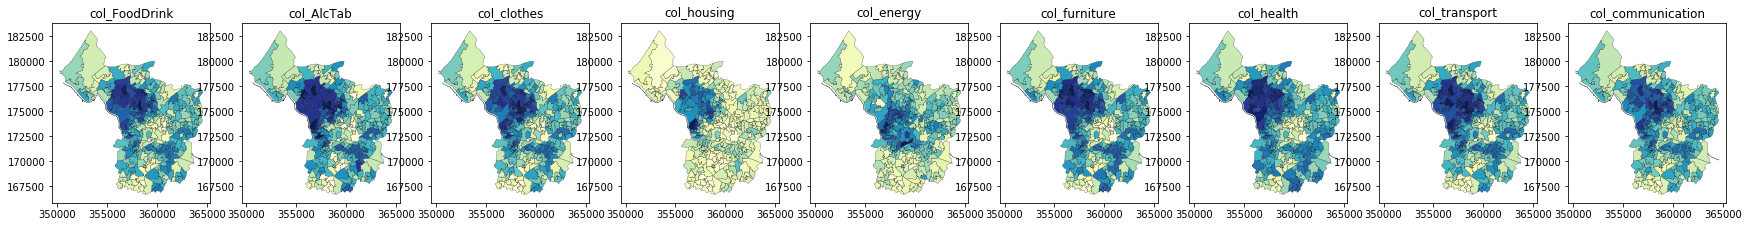

In [78]:
fig, (axs) = plt.subplots(ncols=int((len(cat_str)+1)/2), nrows=1, figsize=(30, 8))

for i in range(0, int((len(cat_str)+1)/2)):
    data_lsoa.join(data_co2[cat_str], how = 'inner')\
             .plot(ax=axs[i],
                   column=cat_str[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(cat_str[i])

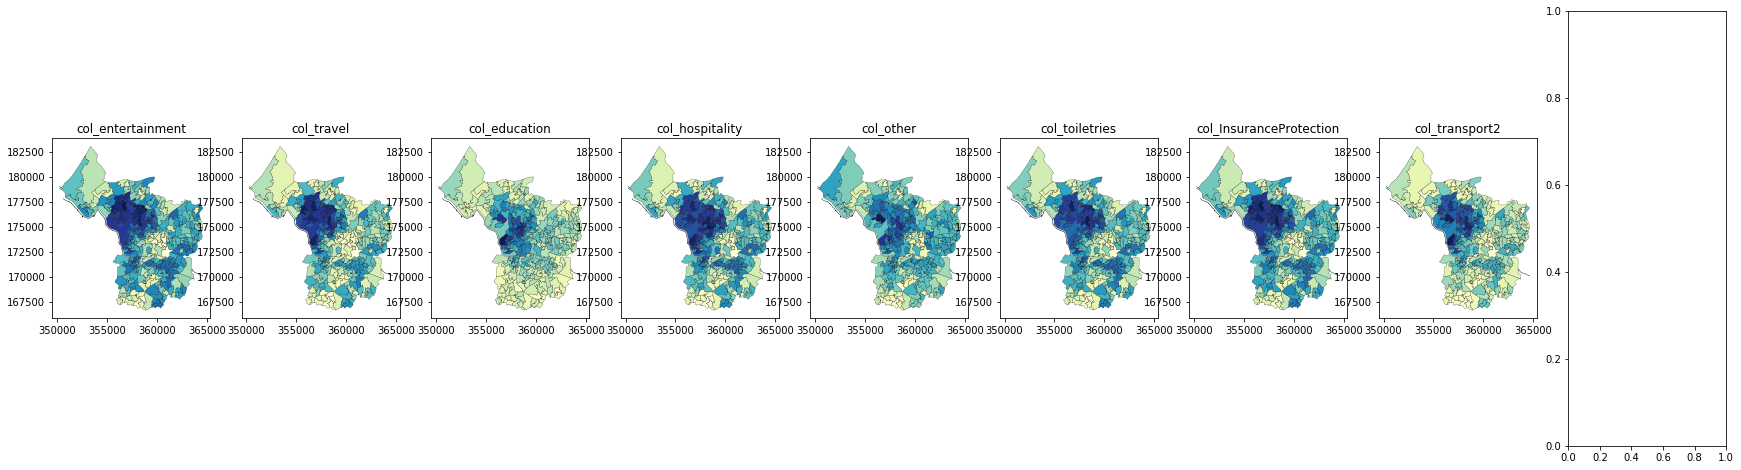

In [79]:
a = (len(cat_str) - int(len(cat_str)/2))

fig, (axs) = plt.subplots(ncols=a, nrows=1, figsize=(30, 8))

for i in range(a, len(cat_str)):
    data_lsoa.join(data_co2[cat_str], how = 'inner')\
             .plot(ax=axs[i-a],
                   column=cat_str[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(cat_str[i])

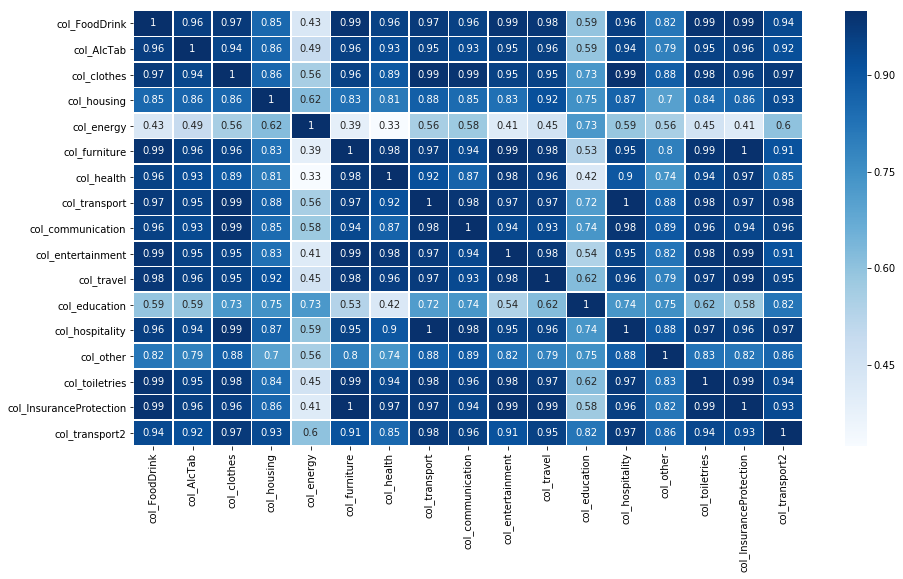

In [31]:
plt.subplots(figsize=(15,8))
sns.heatmap(data_co2[cat_str].corr(), annot=True, cmap='Blues', linewidths=.5)
plt.show()

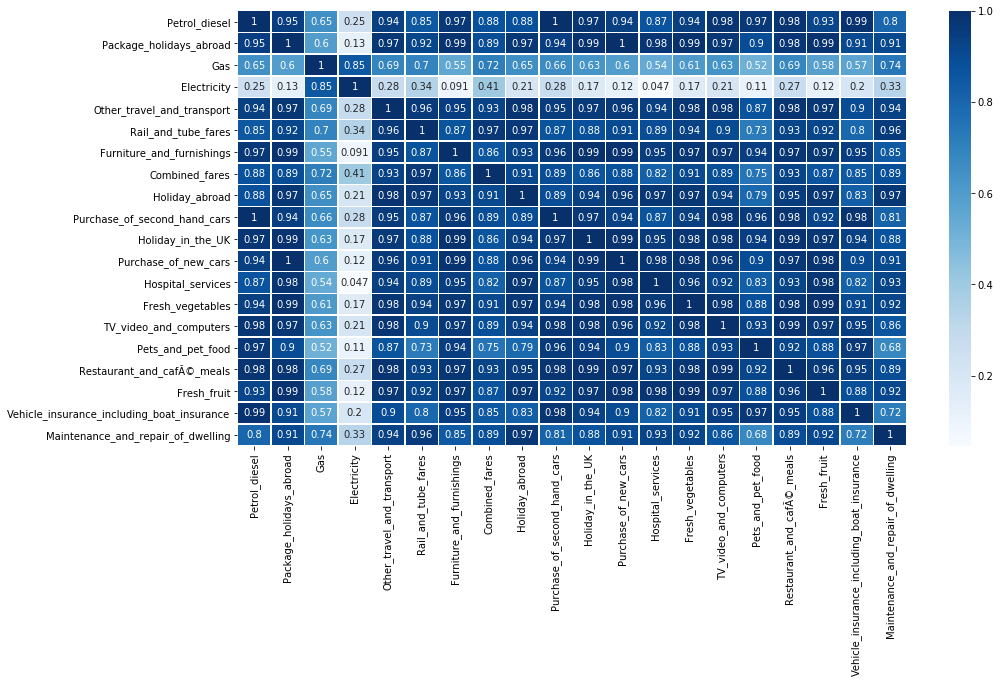

In [32]:
range_sorted = summary_co2.sort_values('range', ascending=False).T.drop(cat_str, axis=1).columns.to_list()

plt.subplots(figsize=(15,8))
sns.heatmap(data_co2[range_sorted[:20]].corr(), annot=True, cmap='Blues', linewidths=.5)
plt.show()

In [80]:
'''
a = range_sorted[:7]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''
# looks like Gas and Electricity may be more linked to housing types / efficiency than to deprivation?

"\na = range_sorted[:7]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

In [81]:
'''
a = range_sorted[7:14]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''

"\na = range_sorted[7:14]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

In [82]:
'''
a = range_sorted[14:21]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''

"\na = range_sorted[14:21]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

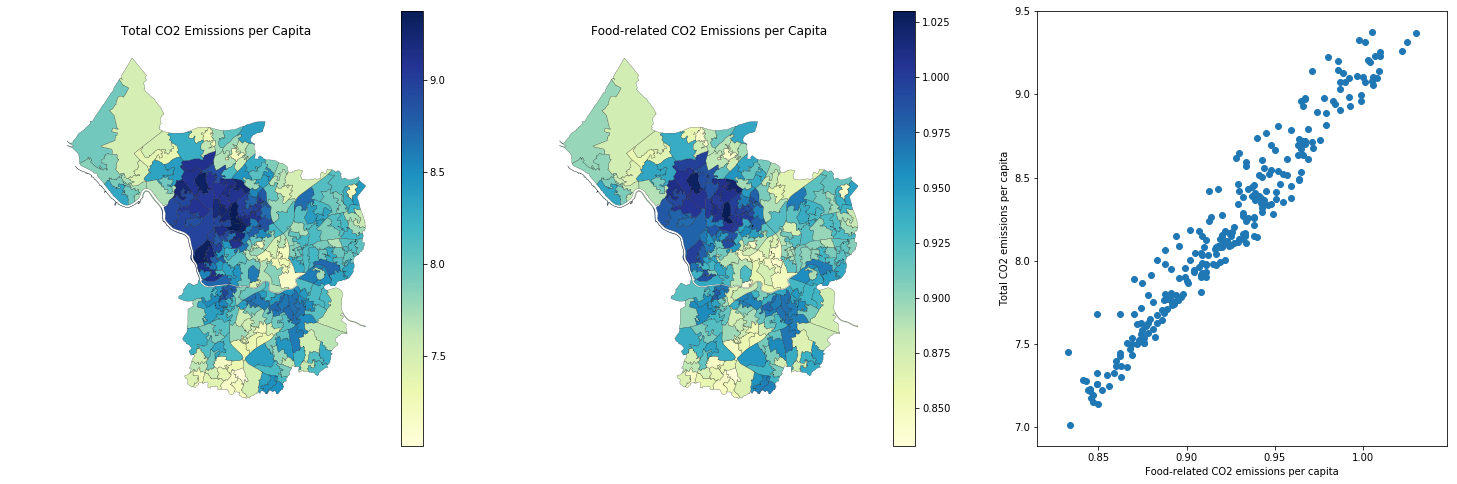

In [87]:
data_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

data_lsoa.join(data_co2, how='right')\
         .plot(ax=axs[0],
               column='TOTAL', 
               cmap='YlGnBu',
               linewidth=0.2, edgecolor='black', 
               legend=True)\
         .set_title("Total CO2 Emissions per Capita")
axs[0].set_axis_off()

data_lsoa.join(data_co2, how='right')\
         .plot(ax=axs[1],
               column='food_total', 
               cmap='YlGnBu',
               linewidth=0.2, edgecolor='black', 
               legend=True)\
         .set_title("Food-related CO2 Emissions per Capita")
axs[1].set_axis_off()

axs[2] = plt.scatter(data_co2['food_total'], data_co2['TOTAL'])
plt.xlabel('Food-related CO2 emissions per capita')
plt.ylabel('Total CO2 emissions per capita')

# plt.savefig('Outputs/total_co2.png')

In [88]:
'''
a = summary_co2.T[col_FoodDrink].T.sort_values('mean', # use 'range', 'mean' or 'max'
                                               ascending=False).index.to_list()[:10] # use [:10], [10:20] or [20]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''

"\na = summary_co2.T[col_FoodDrink].T.sort_values('mean', # use 'range', 'mean' or 'max'\n                                               ascending=False).index.to_list()[:10] # use [:10], [10:20] or [20]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

In [89]:
top_list = summary_co2.T[col_FoodDrink].T.sort_values('mean', ascending=False).index.to_list()[:10]

for item in summary_co2.T[col_FoodDrink].T.sort_values('range', ascending=False).index.to_list()[:10]:
    if item not in top_list:
        top_list.append(item)
        
for item in summary_co2.T[col_FoodDrink].T.sort_values('max', ascending=False).index.to_list()[:10]:
    if item not in top_list:
        top_list.append(item)
        
print(top_list)

# could also look at lowest ranges (staples?)

['Other_meats', 'Fresh_vegetables', 'Fresh_fruit', 'Bread_rice_and_cereals', 'Poultry', 'Other_food_products', 'Buns_cakes_biscuits', 'Beef', 'Other_tubers', 'Milk', 'Cheese_and_curd']


In [130]:
'''
a = top_list

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''  
# maybe lack of milk in affluent area becasue people buy more plant milks? --> or could be just relatively less to other areas
# this would explain why other dairy products are still high --> not as 'trendy' and accessible as plant based milks

"\na = top_list\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

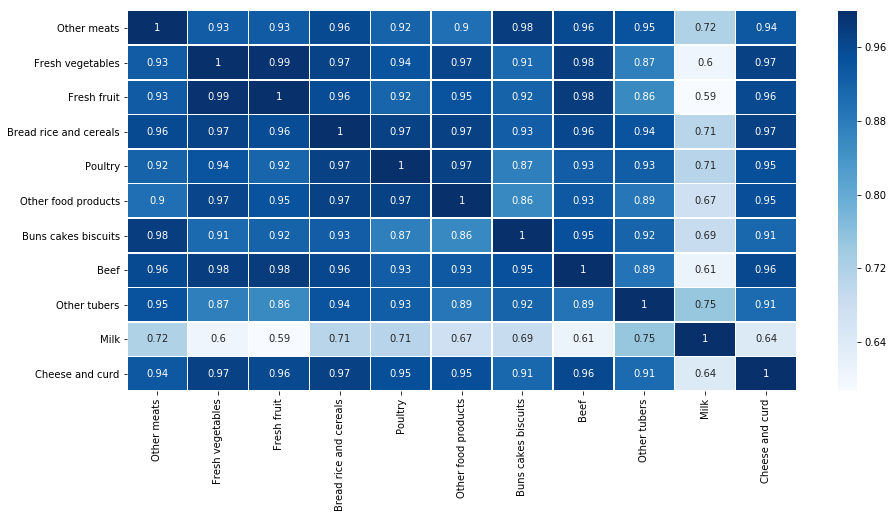

In [102]:
col_names_tl = []
for item in top_list:
    item2 = item.replace('_', ' ')
    col_names_tl.append(item2)

data_tl = data_co2[top_list]
data_tl.columns = col_names_tl

plt.subplots(figsize=(15, 7))
sns.heatmap(data_tl.corr(), annot=True, 
            cmap='Blues', linewidths=.5)
plt.savefig('Outputs/top_cor_an.png')
plt.show()

In [103]:
#data_co2[top_list].plot(kind='box', figsize=(20,8))

In [104]:
#data_co2[top_list].hist(figsize=(10,10), bins=5)

In [105]:
grains = summary_co2.T[col_FoodDrink].columns.to_list()[:2]
baked = summary_co2.T[col_FoodDrink].columns.to_list()[2:4]
meat = summary_co2.T[col_FoodDrink].columns.to_list()[4:11]
dairy_eggs = summary_co2.T[col_FoodDrink].columns.to_list()[11:16]
fats = summary_co2.T[col_FoodDrink].columns.to_list()[16:18]
fruit_veg = summary_co2.T[col_FoodDrink].columns.to_list()[18:27]
sweets_other = summary_co2.T[col_FoodDrink].columns.to_list()[27:33]
drinks_nonalc = summary_co2.T[col_FoodDrink].columns.to_list()[33:]

In [109]:
col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]
str_list = ['Fruit and Veg', 'Meat', 'Grains', 'Dairy and Eggs', 'Other', 'Baked Goods', 'Drinks (non-alc.)', 'Cooking Oils and Fats']
tot_list = []

for i in range(len(col_list)):
    data_co2[str(str_list[i])] = data_co2[col_list[i]].sum(axis=1)
    tot_list.append(str(str_list[i]))

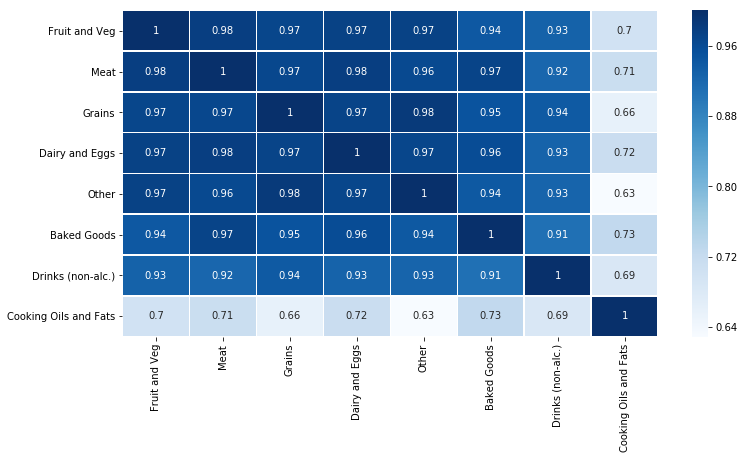

In [115]:
plt.subplots(figsize=(12,6))
sns.heatmap(data_co2[tot_list].corr(), annot=True, 
            cmap='Blues', linewidths=.5)
#plt.savefig('Outputs/cat_cor.png')
plt.show()
# really high co-variance --> likely because does not control for AMOUNT actually consumed, only spending data

# look at total food and/or top_list, becasue covariance so high that there is no need for looking at these separately 

In [117]:
data_co2[tot_list].describe().T.iloc[:,1:].sort_values('mean', ascending=False)#.to_csv('Outputs/cat_means.csv')

,mean,std,min,25%,50%,75%,max
Fruit and Veg,0.302555,0.016896,0.271,0.290,0.301,0.313,0.345
Meat,0.290532,0.013358,0.263,0.280,0.291,0.301,0.320
Dairy and Eggs,0.089909,0.003694,0.083,0.087,0.090,0.092,0.098
Other,0.079399,0.003942,0.071,0.076,0.079,0.083,0.089
Grains,0.066757,0.003148,0.060,0.065,0.067,0.069,0.075
Baked Goods,0.053825,0.002321,0.048,0.052,0.054,0.056,0.059
Drinks (non-alc.),0.030935,0.002041,0.027,0.030,0.031,0.032,0.035
Cooking Oils and Fats,0.009673,0.000579,0.009,0.009,0.010,0.010,0.011


In [47]:
'''
# Scale the data to fit between 0 and 1. This will be useful for the K-Means analysis, as euclidian distance is used. 

min_max_scaler = preprocessing.MinMaxScaler()
data_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[tot_list]))
data_mm.index = data_co2[tot_list].index

to_keep = data_co2[tot_list].columns.to_list()
to_keep_mm = []
for var in to_keep:
    to_keep_mm.append(var + '_mm')
data_mm.columns = to_keep_mm

to_keep_mm2 = to_keep_mm[4:]
to_keep_mm2.append(to_keep_mm[0])
to_keep_mm2.append(to_keep_mm[1])
to_keep_mm2.append(to_keep_mm[2])

data_food_tot = data_co2[tot_list].join(data_mm)[to_keep_mm2]

data_food_tot.head()
'''

"\n# Scale the data to fit between 0 and 1. This will be useful for the K-Means analysis, as euclidian distance is used. \n\nmin_max_scaler = preprocessing.MinMaxScaler()\ndata_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[tot_list]))\ndata_mm.index = data_co2[tot_list].index\n\nto_keep = data_co2[tot_list].columns.to_list()\nto_keep_mm = []\nfor var in to_keep:\n    to_keep_mm.append(var + '_mm')\ndata_mm.columns = to_keep_mm\n\nto_keep_mm2 = to_keep_mm[4:]\nto_keep_mm2.append(to_keep_mm[0])\nto_keep_mm2.append(to_keep_mm[1])\nto_keep_mm2.append(to_keep_mm[2])\n\ndata_food_tot = data_co2[tot_list].join(data_mm)[to_keep_mm2]\n\ndata_food_tot.head()\n"

# CENSUS

In [118]:
# see Data/Census/meta_dict.json for descirptions

# tranfrom ns-sec variable
nssec = ['F359631', 'F359633', 'F359635', 'F359637', 'F359639', 'F359641', 'F359643', 'F359645']
data_ns = data_cen[nssec]

data_cen['max'] = 'empty'
data_cen.loc[data_ns.F359631 == data_ns.max(axis=1), 'max'] = 'S1'
data_cen.loc[data_ns.F359633 == data_ns.max(axis=1), 'max'] = 'S2'
data_cen.loc[data_ns.F359635 == data_ns.max(axis=1), 'max'] = 'S3'
data_cen.loc[data_ns.F359637 == data_ns.max(axis=1), 'max'] = 'S4'
data_cen.loc[data_ns.F359639 == data_ns.max(axis=1), 'max'] = 'S5'
data_cen.loc[data_ns.F359641 == data_ns.max(axis=1), 'max'] = 'S6'
data_cen.loc[data_ns.F359643 == data_ns.max(axis=1), 'max'] = 'S7'
data_cen.loc[data_ns.F359645 == data_ns.max(axis=1), 'max'] = 'S8'

# Create Dummy Variables
nssec_dm = pd.get_dummies(data_cen['max'], prefix='nssec')
data_cen = data_cen.join(nssec_dm)
#data_cen = data_cen.drop(['nssec_S8'], axis=1)

#transform other variables
data_cen['emp_ft'] = data_cen['F1393'] + data_cen['F1395'] + data_cen['F1397']
data_cen['bdr_1p'] = data_cen['F2071'] + data_cen['F2073']
data_cen['eth_w'] = data_cen['F1664'] + data_cen['F1665'] + data_cen['F1666'] + data_cen['F1667']
data_cen['eth_w_ln'] = 1/(data_cen['eth_w'])
data_cen['sec8_ln'] = np.log(data_cen['F359645'])
data_cen['buk_ln'] = np.log(data_cen['F884'])
data_cen['eur'] = data_cen['F1221'] + data_cen['F1233']
data_cen['noneur'] = 1-data_cen['eur']
data_cen['ptrs'] = data_cen['F209'] + data_cen['F210']

# All

In [49]:
'''
col_list = data.columns.to_list()

fig, (axs) = plt.subplots(ncols=len(col_list), nrows=1, figsize=(30, 8))

for i in range(len(col_list)):
    data_lsoa.join(data, how = 'inner').dropna(axis=1)\
             .plot(ax=axs[i],
                   column=col_list[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(col_list[i])
'''

"\ncol_list = data.columns.to_list()\n\nfig, (axs) = plt.subplots(ncols=len(col_list), nrows=1, figsize=(30, 8))\n\nfor i in range(len(col_list)):\n    data_lsoa.join(data, how = 'inner').dropna(axis=1)             .plot(ax=axs[i],\n                   column=col_list[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(col_list[i])\n"

In [119]:
data_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)

In [136]:

col_names={'F185':'age_med', 'F184':'age_mean', 'F1916':'act_lim', 'F1399':'unempl', 'TOTAL':'total', 'a_ln':'IMD', 'b_ln':'Income Deprivation'}
'''
cen_keep = ['F2266', 'buk_ln', 'F185', 'F1816', 'emp_ft', 'F1399', 'F1916', 'bdr_1p', 'ptrs']
data_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)
data = data_co2[['TOTAL', 'food_total', 'Restaurant_and_cafÃ©_meals']].join(data_cen[cen_keep], how='inner').join(data_imd[['b_ln', 'a_ln']]).rename(columns=col_names)

plt.subplots(figsize=(16,8))
sns.heatmap(data.corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()
'''

"\ncen_keep = ['F2266', 'buk_ln', 'F185', 'F1816', 'emp_ft', 'F1399', 'F1916', 'bdr_1p', 'ptrs']\ndata_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)\ndata = data_co2[['TOTAL', 'food_total', 'Restaurant_and_cafÃ©_meals']].join(data_cen[cen_keep], how='inner').join(data_imd[['b_ln', 'a_ln']]).rename(columns=col_names)\n\nplt.subplots(figsize=(16,8))\nsns.heatmap(data.corr(), annot=True, cmap='RdBu', linewidths=.5)\nplt.show()\n"

In [121]:
'''
sns.set(style="ticks")
sns.pairplot(data)
'''

'\nsns.set(style="ticks")\nsns.pairplot(data)\n'

In [123]:
"""
['a. Index of Multiple Deprivation (IMD)',
 'b. Income Deprivation Domain',
 'c. Employment Deprivation Domain',
 'd. Education, Skills and Training Domain',
 'e. Health Deprivation and Disability Domain',
 'f. Crime Domain',
 'g. Barriers to Housing and Services Domain',
 'h. Living Environment Deprivation Domain',
 'i. Income Deprivation Affecting Children Index (IDACI)']
 """

'''
col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]

check_var = col_list[7]

plt.subplots(figsize=(30, 15))
sns.heatmap(data_co2[check_var].join(data_imd[col_list_2]).corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()

# h most different for all foods, also check f and g
# maybe milk is weird because people buy plant milks more? 
'''

"\ncol_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]\n\ncheck_var = col_list[7]\n\nplt.subplots(figsize=(30, 15))\nsns.heatmap(data_co2[check_var].join(data_imd[col_list_2]).corr(), annot=True, cmap='RdBu', linewidths=.5)\nplt.show()\n\n# h most different for all foods, also check f and g\n# maybe milk is weird because people buy plant milks more? \n"

In [124]:
'''
sns.set(style="ticks")
sns.pairplot(data_imd[col_list_2], kind = 'reg', plot_kws={'line_kws':{'color':'red'}})
'''

'\nsns.set(style="ticks")\nsns.pairplot(data_imd[col_list_2], kind = \'reg\', plot_kws={\'line_kws\':{\'color\':\'red\'}})\n'

In [125]:
'''
col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]

check_var = col_list[0]

sns.set(style="ticks")
sns.pairplot(data_co2[check_var].join(data_imd[['a_ln', 'f', 'g', 'h_ln']]), kind = 'reg', plot_kws={'line_kws':{'color':'red'}})
'''

# h maybe correlates with: Potatoes, Other-tubers, Lamb, Bacon_and_ham, Pasta_products, Milk, Butter, Other_food_products, Pastry, Tea, Mineral_water, Soft_drinks, Margarine

'\ncol_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]\n\ncheck_var = col_list[0]\n\nsns.set(style="ticks")\nsns.pairplot(data_co2[check_var].join(data_imd[[\'a_ln\', \'f\', \'g\', \'h_ln\']]), kind = \'reg\', plot_kws={\'line_kws\':{\'color\':\'red\'}})\n'

In [127]:
# col_list_3 = ['Potatoes', 'Other_tubers', 'Lamb', 'Bacon_and_ham', 'Pasta_products', 'Milk', 'Butter', 'Other_food_products', 'Pastry', 'Tea', 'Mineral_water', 'Soft_drinks', 'Margarine']

'''
col_list_3 = ['Potatoes', 'Lamb', 'Bacon_and_ham', 'Butter', 'Pastry', 'Tea', 'Mineral_water', 'Soft_drinks', 'Margarine']

plt.subplots(figsize=(16, 8))
sns.heatmap(data_co2[col_list_3].join(data_imd[['a_ln']]).corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()
'''

"\ncol_list_3 = ['Potatoes', 'Lamb', 'Bacon_and_ham', 'Butter', 'Pastry', 'Tea', 'Mineral_water', 'Soft_drinks', 'Margarine']\n\nplt.subplots(figsize=(16, 8))\nsns.heatmap(data_co2[col_list_3].join(data_imd[['a_ln']]).corr(), annot=True, cmap='RdBu', linewidths=.5)\nplt.show()\n"

In [137]:
'''
a = ['Restaurant_and_cafÃ©_meals', 'a_ln']

fig, (axs) = plt.subplots(ncols=int(len(a)), nrows=1, figsize=(30, 8))

data_a = data_lsoa.join(data_imd, how = 'inner').join(data_co2, how = 'inner')

for i in range(len(a)):
    data_a.plot(ax=axs[i],
                column=a[i], 
                cmap='YlGnBu',
                scheme = 'quantiles',
                linewidth=0.2, edgecolor='black',
                legend=True
                )\
           .set_title(a[i], size=13)
    axs[i].set_axis_off()
'''

"\na = ['Restaurant_and_cafÃ©_meals', 'a_ln']\n\nfig, (axs) = plt.subplots(ncols=int(len(a)), nrows=1, figsize=(30, 8))\n\ndata_a = data_lsoa.join(data_imd, how = 'inner').join(data_co2, how = 'inner')\n\nfor i in range(len(a)):\n    data_a.plot(ax=axs[i],\n                column=a[i], \n                cmap='YlGnBu',\n                scheme = 'quantiles',\n                linewidth=0.2, edgecolor='black',\n                legend=True\n                )           .set_title(a[i], size=13)\n    axs[i].set_axis_off()\n"

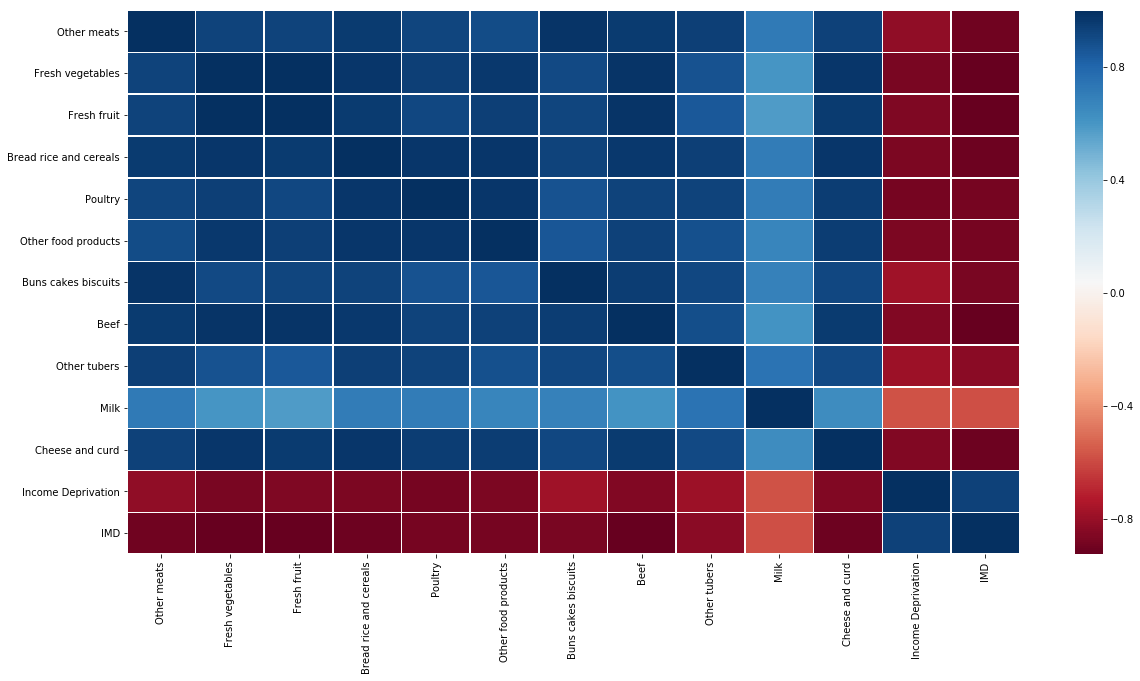

In [141]:
plt.subplots(figsize=(20,10))
sns.heatmap(data_tl.join(data_imd[['b_ln', 'a_ln']]).rename(columns=col_names).corr(),# annot=True, 
            cmap='RdBu', linewidths=.5)
plt.savefig('Outputs/tl_imd.png')
plt.show()

In [142]:
'''
sns.set(style="ticks")
sns.pairplot(data_co2[top_list].join(data_imd[['b_ln', 'a_ln']]))
'''

'\nsns.set(style="ticks")\nsns.pairplot(data_co2[top_list].join(data_imd[[\'b_ln\', \'a_ln\']]))\n'

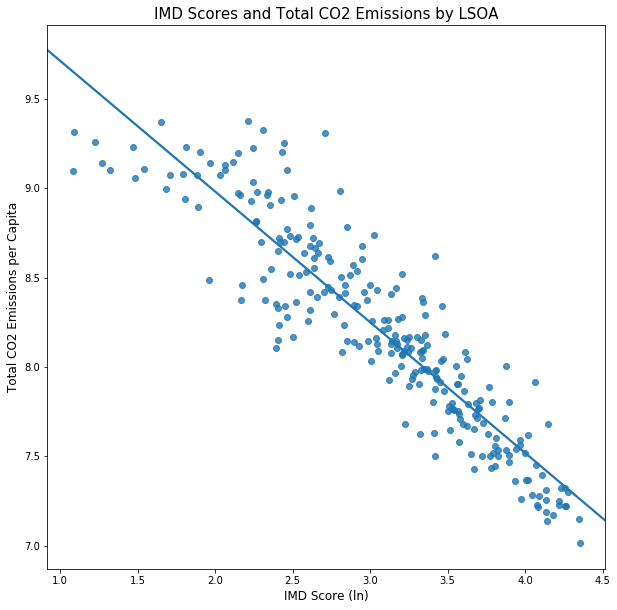

In [195]:
f, (ax) = plt.subplots(nrows =1, ncols=1, figsize=(10,10))

sns.regplot(ax=ax, x="a_ln", y="total", data=data, ci=None)
ax.set_title("IMD Scores and Total CO2 Emissions by LSOA", size=15)
plt.xlabel('IMD Score (ln)', size=12)
plt.ylabel('Total CO2 Emissions per Capita', size=12)

plt.savefig('Outputs/imd_total_plot.png')

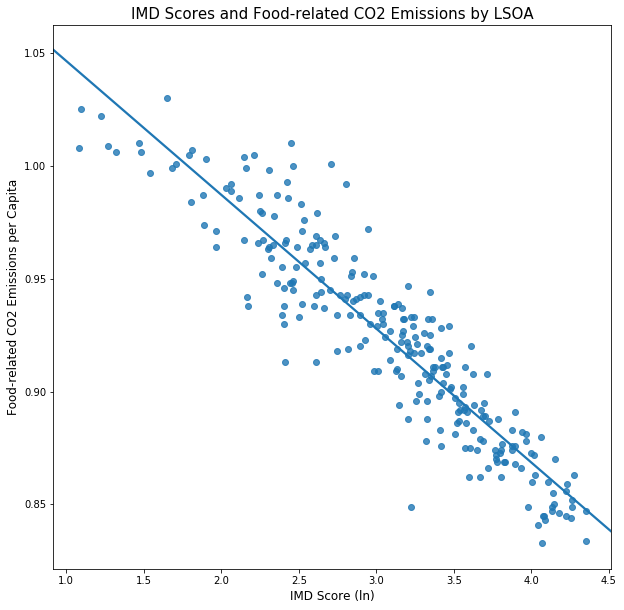

In [196]:
f, (ax1) = plt.subplots(nrows =1, ncols=1, figsize=(10,10))

sns.regplot(ax=ax1, x="a_ln", y="food_total", data=data, ci=None)
#ax1.set_ylim(0.8, 1.07)
plt.xlabel('IMD Score (ln)', size=12)
plt.ylabel('Food-related CO2 Emissions per Capita', size=12)

ax1.set_title("IMD Scores and Food-related CO2 Emissions by LSOA", size=15)
plt.savefig('Outputs/imd_food_plot.png')

# Regression

In [143]:
data.head()

,total,food_total,Restaurant_and_cafÃ©_meals,F2266,buk_ln,age_med,F1816,emp_ft,unempl,act_lim,bdr_1p,ptrs,b_ln,a_ln
LSOA,,,,,,,,,,,,,,
E01014485,8.178,0.922,0.061,0.492570,-0.924997,33.0,0.568571,0.156212,0.034440,0.068244,0.211353,0.236253,-1.720314,3.158362
E01014486,7.806,0.891,0.056,0.381096,-1.052848,30.0,0.482446,0.165730,0.100187,0.079845,0.226015,0.219672,-1.087643,3.892677
E01014487,8.783,0.959,0.068,0.534500,-0.857432,28.0,0.523169,0.110512,0.020216,0.039000,0.177045,0.261837,-2.717949,2.853939
E01014488,8.519,0.947,0.065,0.523833,-0.896050,31.0,0.581699,0.148148,0.035760,0.051179,0.225847,0.242259,-1.660679,3.204331
E01014489,8.044,0.908,0.059,0.496879,-0.939125,29.0,0.431567,0.150772,0.076294,0.065751,0.201754,0.144775,-1.514082,3.622125


In [197]:
def calculate_model(out, pred):
    m_f = str(out) + ' ~ ' + str(pred[0])
    for var in pred[1:]:
        m_f = cp.copy(m_f) + ' + ' + str(var)
    
    # full dataset
    m=sm.ols(m_f, data).fit()

    # cross-validation
    x_train, x_test, y_train, y_test = model_selection.train_test_split(data[pred], data[out], test_size= 0.2, random_state=1234)
    if out == 'total':
        m_tr=sm.ols(m_f, x_train.assign(total = y_train)).fit()
    elif out == 'food_total':
        m_tr=sm.ols(m_f, x_train.assign(food_total = y_train)).fit()
    else:
        pass
    y_pred=m_tr.predict(x_test)
    results = pd.Series({'0-Full Dataset':m.rsquared, '1-Train Set':m_tr.rsquared, '2-Test Set':metrics.r2_score(y_test, y_pred)})
    
    # bootstrap
    rids=np.arange(data.shape[0])
    np.random.shuffle(rids)
    r2s=model_selection.cross_val_score(LinearRegression(),
                                        data.iloc[rids,:][pred],
                                        data.iloc[rids,:][out],
                                        cv=10,
                                        scoring='r2')
    
    print('Base model: ', '\n', m.summary(), '\n', '\n', 
          'Model results: ', '\n', results, '\n', '\n', 
          'Bootstrap results: ',  '\n', r2s, '\n', '\n',
          'Bootstrap mean: ', r2s.mean())
    
    return(m)

Base model:  
                             OLS Regression Results                            
Dep. Variable:             food_total   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1573.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          1.65e-112
Time:                        13:53:13   Log-Likelihood:                 697.92
No. Observations:                 263   AIC:                            -1392.
Df Residuals:                     261   BIC:                            -1385.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1058      0.005    2

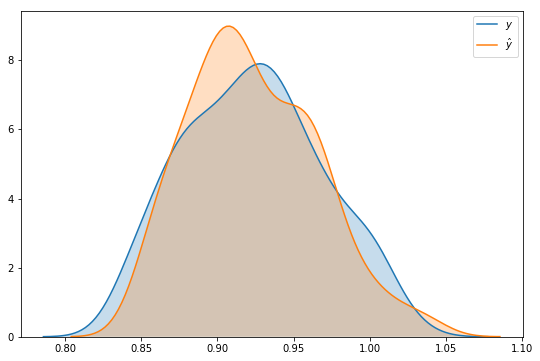

In [198]:
pred = ['a_ln'] # try ['a_ln'], ['a_ln', 'F2266'], ['b_ln', 'F1816'], ['b_ln', 'ptrs'], ['age_med', 'b_ln']
out = 'food_total' # try 'total', 'food_total'

#compare distributions of predicted and actual values for both models 
f, ax = plt.subplots(1, figsize=(9, 6))

sns.kdeplot(data[out], shade=True, ax=ax, label='$y$')
sns.kdeplot(calculate_model(out, pred).fittedvalues, shade=True, ax=ax, label='$\hat{y}$')

plt.show()

Base model:  
                             OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1338.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          9.92e-105
Time:                        13:53:43   Log-Likelihood:                 15.967
No. Observations:                 263   AIC:                            -27.93
Df Residuals:                     261   BIC:                            -20.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4440      0.063    1

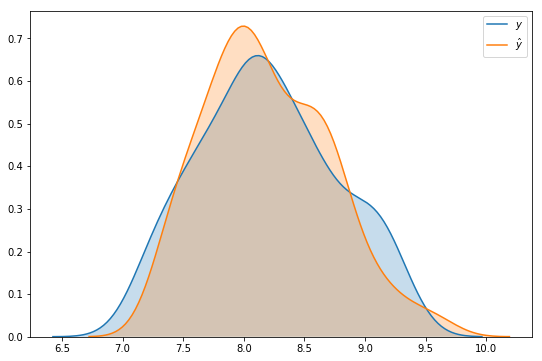

In [199]:
pred = ['a_ln'] # try ['a_ln'], ['a_ln', 'F2266'], ['b_ln', 'F1816'], ['b_ln', 'ptrs'], ['age_med', 'b_ln']
out = 'total' # try 'total', 'food_total'

#compare distributions of predicted and actual values for both models 
f, ax = plt.subplots(1, figsize=(9, 6))

sns.kdeplot(data[out], shade=True, ax=ax, label='$y$')
sns.kdeplot(calculate_model(out, pred).fittedvalues, shade=True, ax=ax, label='$\hat{y}$')

plt.show()

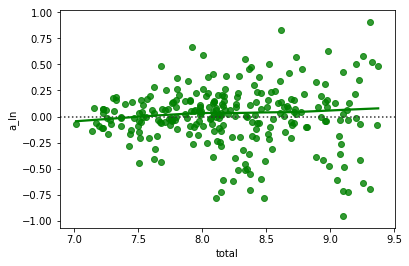

In [200]:
sns.residplot(data[out], data['a_ln'], lowess=True, color="g")

# Spatial weights

In [201]:
spatial_data = data_lsoa.join(data, how='inner')

In [202]:
spatial_data.head()

,FID_1,geo_label,geo_labelw,Count_,geometry,total,food_total,Restaurant_and_cafÃ©_meals,F2266,buk_ln,age_med,F1816,emp_ft,unempl,act_lim,bdr_1p,ptrs,b_ln,a_ln
E01014584,66,Bristol 045E,None,1,"POLYGON ((358645.634 170187.736, 358640.859 17...",7.539,0.882,0.055,0.422828,-0.808689,31.0,0.814727,0.154506,0.045064,0.105528,0.363248,0.390244,-1.139403,3.938237
E01014539,114,Bristol 025A,None,1,"POLYGON ((358951 174048, 358959.518 174040.699...",8.664,0.950,0.067,0.509815,-0.894848,27.0,0.456425,0.096234,0.016736,0.038713,0.201531,0.232348,-2.733214,2.643548
E01014504,380,Bristol 041B,None,1,"POLYGON ((357372.001 171182.194, 357369.784 17...",8.538,0.952,0.066,0.466311,-0.761473,34.0,0.662544,0.089368,0.038521,0.064043,0.201220,0.343505,-2.407835,2.918420
E01014654,430,Bristol 056A,None,1,"POLYGON ((360104.977 174206.128, 360105.018 17...",7.521,0.873,0.054,0.154111,-1.334700,28.0,0.584722,0.181607,0.088475,0.086096,0.394767,0.321494,-0.991526,3.999979
E01014669,540,Bristol 020D,None,1,"POLYGON ((358550 175095, 358551 175095, 358551...",9.375,1.005,0.075,0.468439,-0.838807,30.0,0.586466,0.090756,0.020168,0.033223,0.161031,0.332271,-3.381101,2.209484


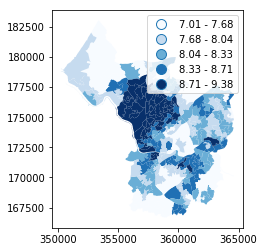

In [203]:
spatial_data.plot(column = 'total', scheme = 'quantiles', cmap ='Blues', legend = True)

In [204]:
spatial_data.reset_index().to_file('Data/Spatial/spatial_data.shp')

In [205]:
# two observations are neighbours if they share one point
w_queen = ps.weights.Queen.from_dataframe(spatial_data)

In [206]:
#sns.distplot(queen_card, bins=8)

In [207]:
print(w_queen.n, '\n', # Number of observations
      w_queen.mean_neighbors, '\n', # Average number of neighbors
      w_queen.min_neighbors, '\n', # Min number of neighbors
      w_queen.max_neighbors, '\n', # Max number of neighbors
      w_queen.islands, '\n', # Islands (observations disconnected)
     )

263 
 5.4600760456273765 
 2 
 10 
 [] 



# Spatial Lag

The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself

In [208]:
# Row-standardize the queen matrix
'''
    O: original, returning the object to the initial state.
    B: binary, with every neighbor having assigned a weight of one.
    R: row, with all the neighbors of a given observation adding up to one.
    V: variance stabilizing, with the sum of all the weights being constrained to the number of observations.
'''
w_queen.transform = 'R'
# Compute spatial lag of `imd_score`
w_queen_score = ps.lag_spatial(w_queen, spatial_data['a_ln'])
# Add as column
spatial_data['w_queen_imd'] = w_queen_score

# Moran's Plot

Text(0.5,1,"Moran's plot for total emissions")

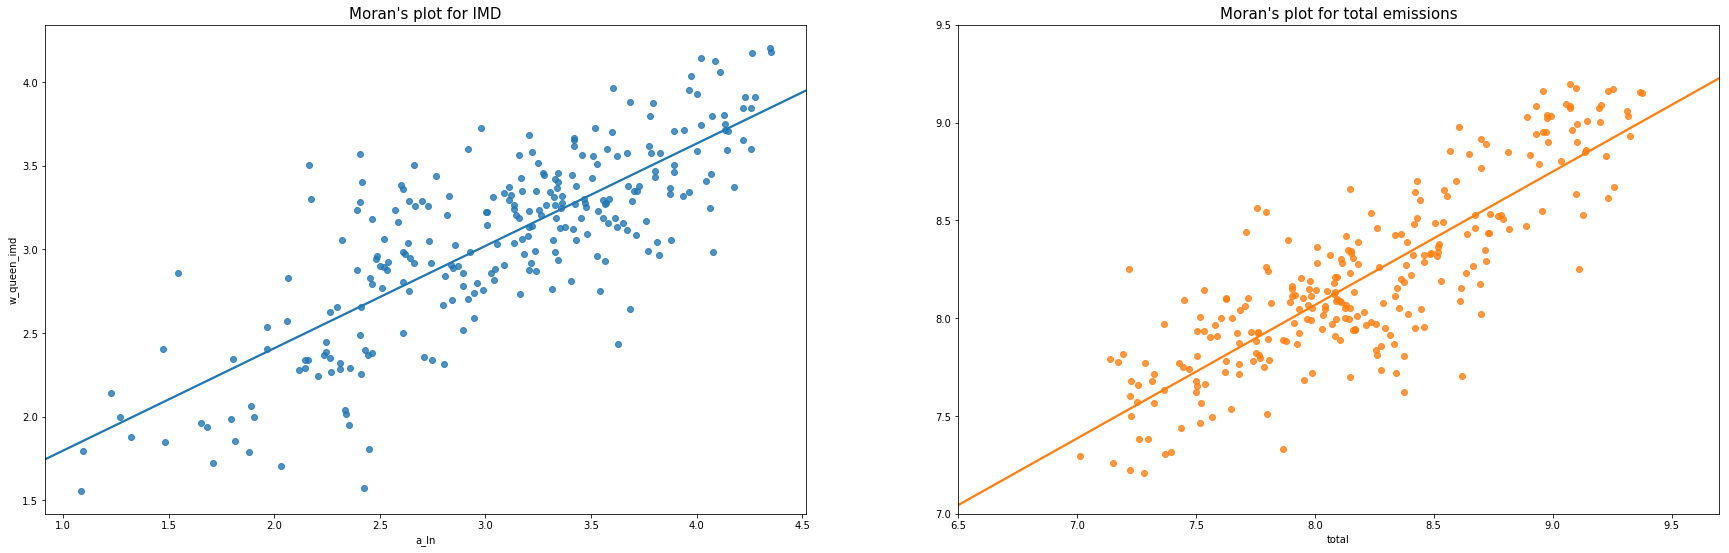

In [209]:
# Setup the figure and axis
f, (ax, ax1) = plt.subplots(nrows =1, ncols=2, figsize=(30, 9))

sns.regplot(ax=ax, x="a_ln", y="w_queen_imd", data=spatial_data, ci=None)
ax.set_title("Moran's plot for IMD", size=15)

sns.regplot(ax=ax1, x=spatial_data["total"], y=ps.lag_spatial(w_queen, spatial_data['total']), ci=None)
ax1.set_ylim(7, 9.5)
ax1.set_xlim(6.5, 9.7)
ax1.set_title("Moran's plot for total emissions", size=15)

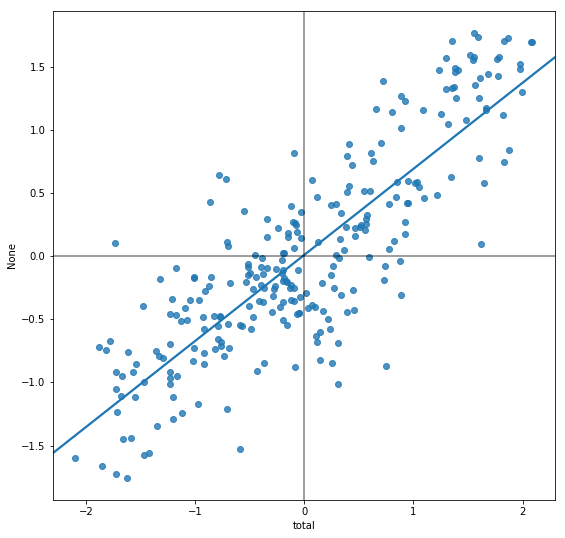

In [210]:
# Standardize total emissions to see quartiles (HH, HL, LH, LL)
std_co2 = (spatial_data['total'] - spatial_data['total'].mean()) / spatial_data['total'].std()
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
std_w_co2 = pd.Series(ps.lag_spatial(w_queen, std_co2), index=std_co2.index)

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_co2, y=std_w_co2, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# Spatial autocorrelation and Exploratory Spatial Data Analysis - Lab 06

In [211]:
np.random.seed(123)
w = ps.weights.Queen.from_dataframe(spatial_data)
w.transform = 'R'
spatial_data['w_total'] = ps.lag_spatial(w, spatial_data['total'])

# standardised total emissions
spatial_data['total_std'] = (spatial_data['total'] - spatial_data['total'].mean()) / spatial_data['total'].std()
spatial_data['w_total_std'] = ps.lag_spatial(w, spatial_data['total_std'])

## Global Spatial autocorrelation

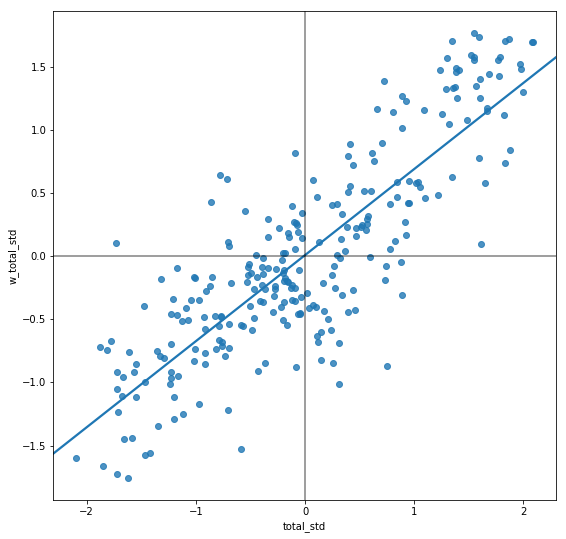

'\nThe plot displays a positive relationship between both variables. \nThis is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. \nThis means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values.\n'

In [212]:
# Moran plot

f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='total_std', y='w_total_std', data=spatial_data, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()
'''
The plot displays a positive relationship between both variables. 
This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. 
This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values.
'''

In [213]:
# Moran's I
mi = ps.Moran(spatial_data['total'], w) # Note how we do not need to use the standardized version in this context as we will not represent it visually.
print("Moran's I: " + str(mi.I), '\n', "p-value: " + str(mi.p_sim))

'''
Moran's I is good tool to summarize a dataset into a single value that informs about its degree of clustering. 
However, it is not an appropriate measure to identify areas within the map where specific values are located.
'''

Moran's I: 0.6815938922451394 
 p-value: 0.001


"\nMoran's I is good tool to summarize a dataset into a single value that informs about its degree of clustering. \nHowever, it is not an appropriate measure to identify areas within the map where specific values are located.\n"

## Local Spatial autocorrelation

Can help identify *where* clusters are

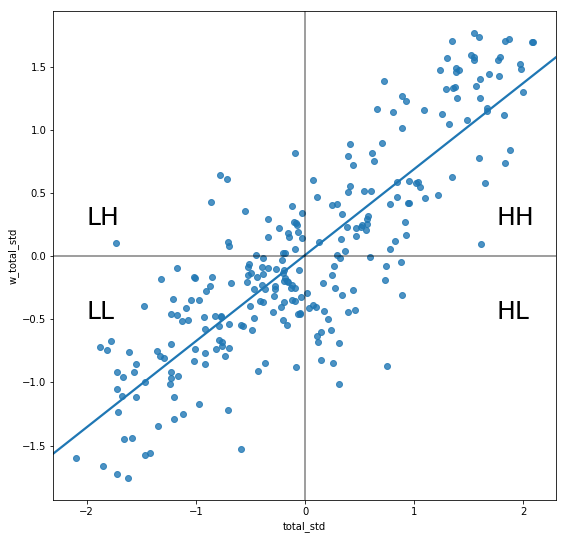

In [214]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='total_std', y='w_total_std', data=spatial_data, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.25, "HH", fontsize=25)
plt.text(1.75, -0.5, "HL", fontsize=25)
plt.text(-2, 0.25, "LH", fontsize=25)
plt.text(-2, -0.5, "LL", fontsize=25)
plt.show()

In [215]:
'''
Now we need to see how each of these compares to what we would expect by random chance. 
This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the 
intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) 
or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as
many statistics as original observations.
'''

lisa = ps.Moran_Local(spatial_data['total'], w)

# Store p-values
spatial_data['pvalue'] = lisa.p_sim
# Break observations into significant or not
spatial_data['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
spatial_data['quadrant'] = lisa.q

In [216]:
quadrant_code = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
quad_def=[quadrant_code[i] for i in spatial_data['quadrant']]

spatial_data['quadrant_def'] = quad_def

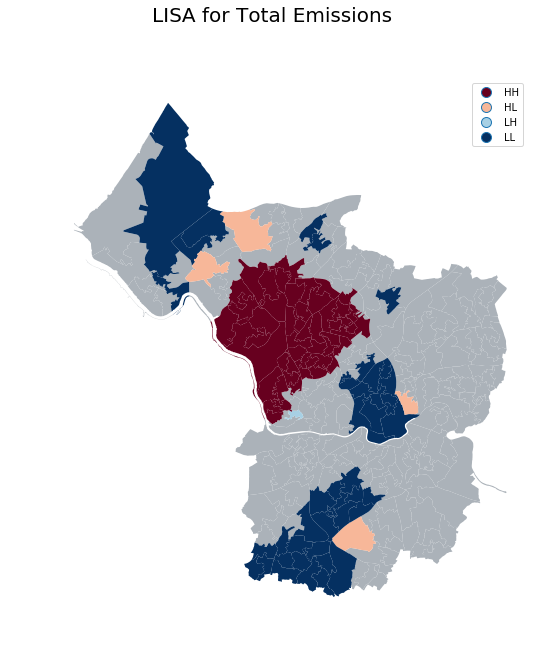

In [219]:
f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
f.suptitle('LISA for Total Emissions', size=20)

# short way
# Plot insignificant clusters
ns = spatial_data.loc[spatial_data['significant']==False, 'geometry']
ns.plot(ax=ax1, color='#abb2b9')

# Plot HH clusters
sig = spatial_data.loc[spatial_data['significant']==True]
sig.plot(ax=ax1, column = 'quadrant_def', cmap='RdBu', legend= True)
ax1.set_axis_off()

plt.savefig('Outputs/autocorr_map.png')

# Clustering, spatial clustering, and geodemographics - Lab 08

In [220]:
col_FoodDrink[:39].append('Restaurant_and_cafÃ©_meals')

In [221]:
min_max_scaler = preprocessing.MinMaxScaler()
data_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[col_FoodDrink[:40]]))
data_mm.index = data_co2[col_FoodDrink[:40]].index

to_keep = data_co2[col_FoodDrink[:40]].columns.to_list()
to_keep_mm = []
for var in to_keep:
    to_keep_mm.append(var + '_mm')
data_mm.columns = to_keep_mm

to_keep_mm2 = to_keep_mm[4:]
to_keep_mm2.append(to_keep_mm[0])
to_keep_mm2.append(to_keep_mm[1])
to_keep_mm2.append(to_keep_mm[2])

data_8 = spatial_data.join(data_mm[to_keep_mm2])

In [222]:
w = ps.weights.Queen.from_dataframe(data_8)

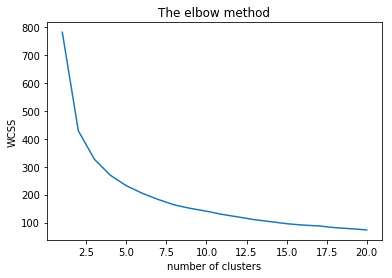

In [223]:
# Perform PCA
pca=PCA(n_components=None) # Create an instance of the PCA class

# Fit the data to the model
pcaResults=pca.fit_transform(data_8[to_keep_mm2])
explained_variance=pca.explained_variance_ratio_ # Extract the varience

# use the elbow method
wcss=[]

for i in range(1,21):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(pcaResults)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS results
plt.plot(range(1,21), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

In [224]:
# add spatial contraint
sagg13 = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w.sparse)

# This line is required to obtain the same results always
np.random.seed(1234)
# Run the clustering algorithm
sagg13cls = sagg13.fit(data_8[to_keep_mm2])

# add labels as column
data_8['sagg13cls'] = sagg13cls.labels_

In [309]:
import random

mycmap_list = ['#f1c40f', '#619864', '#2a80b9', '#c1392b', '#bec3c7']
random.shuffle(mycmap_list)
mycmap = matplotlib.colors.ListedColormap(mycmap_list, N=None)

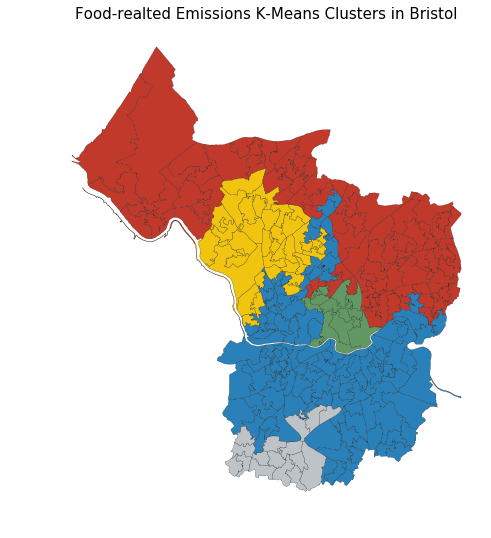

In [311]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
data_8.plot(column='sagg13cls', cmap=mycmap, categorical=True, legend=False, linewidth=0.2, facecolor='white', edgecolor='k', ax=ax)
# Add title
plt.title('Food-realted Emissions K-Means Clusters in Bristol', size=15)
ax.set_axis_off()
# Display the map
plt.savefig('Outputs/food_clusters.png')
plt.show()

In [226]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

In [227]:
# Dissolve the polygons based on `sagg13cls`
food_clusters = gpd.GeoSeries(data_8.groupby(data_8['sagg13cls'])\
                                    .apply(dissolve),
                              crs=data_8.crs)

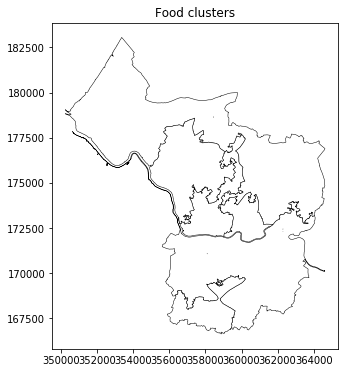

In [279]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
food_clusters.plot(ax=ax, linewidth=0.5, facecolor='white', edgecolor='k')

# Add title
plt.title('Food clusters')
# Display the map
plt.show()

In [236]:
food_2 = gpd.GeoDataFrame(food_clusters, crs=data_8.crs).rename(columns={0:'geometry'})

In [237]:
food_2.head()

,geometry
sagg13cls,
0,"(POLYGON ((358002.5 172148.526, 357886.7 17215..."
1,"(POLYGON ((353219.815 175865.997, 353221.099 1..."
2,"POLYGON ((358814.19 168516.497, 358814.405 168..."
3,"(POLYGON ((358100.943 174112.588, 358082.727 1..."
4,"POLYGON ((359304 172263, 359311.389 172269.085..."


In [238]:
all_spatial = gpd.sjoin(data_8, food_2).drop('index_right', axis=1)

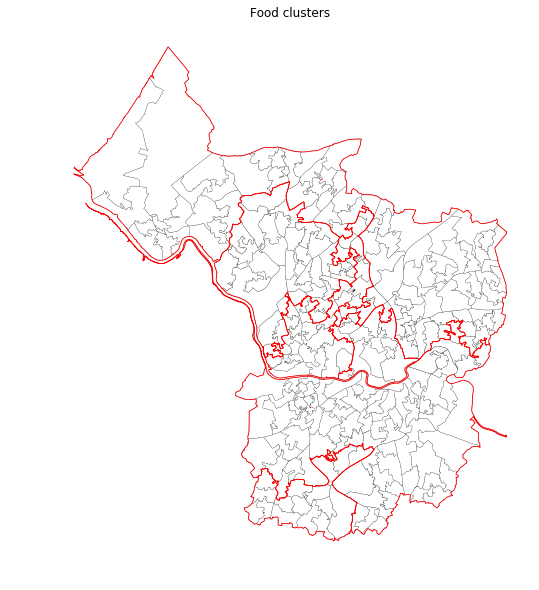

In [294]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot boundary lines
all_spatial.plot(ax=ax, linewidth=0.2, facecolor='white', edgecolor='k')
#food_clusters.plot(ax=ax, linewidth=0.5, facecolor='white', edgecolor='k')
food_2.boundary.plot(ax=ax, linewidth=0.8, edgecolor='red')
ax.set_axis_off()
# Add title
plt.title('Food clusters')
# Display the map
plt.show()

In [253]:
new_cols = []
for item in col_FoodDrink:
    new_cols.append(item + '_mm')
new_cols.append('food_total')
new_cols.append('total')
new_cols.append('sagg13cls')
new_cols.remove('Pastry_mm')

In [257]:
all_spatial[new_cols].groupby('sagg13cls').describe().T.to_csv('Outputs/summary_by_cluster.csv')